In [1]:
import os
import sys
thread = sys.argv[1]
os.environ["OMP_NUM_THREADS"] = str(thread) # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = str(thread) # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = str(thread) # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread) # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = str(thread) # export NUMEXPR_NUM_THREADS=6
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import qml
from qml.math import cho_solve
from qml.kernels import gaussian_kernel
from qml.kernels import laplacian_kernel


In [2]:
X = np.load("./data/X.npy")
y = np.loadtxt("./data/E_def2-tzvp.dat")

In [3]:
class KRR():
    def __init__(self, alpha=1e-8, library = "qml", sigma = 720, kernel='gaussian'):
        self.alpha = alpha
        self.sigma = sigma
        self.kernel = kernel
        self.library = library
        self.is_fit = False
        self.avg_mae = 0
        self.avg_training_time_cpu = 0
        self.avg_testing_time_cpu = 0
        self.avg_training_time_wall = 0
        self.avg_testing_time_wall = 0

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        start_cpu = time.process_time()
        start_wall = time.perf_counter()
        if self.library == "qml":
            if self.kernel == 'gaussian':
                K = gaussian_kernel(X, X, self.sigma)    
            elif self.kernel == 'laplacian':
                K = laplacian_kernel(X, X, self.sigma)
            K[np.diag_indices_from(K)] += self.alpha 
            self.beta = cho_solve(K, y)
        elif self.library == "scikit-learn":
            if self.kernel == 'gaussian':
                self.krr = KernelRidge(kernel = "rbf", gamma = 1/self.sigma, alpha=self.alpha)
            elif self.kernel == 'laplacian':
                self.krr = KernelRidge(kernel = "laplacian", gamma = 1/self.sigma, alpha=self.alpha)
            self.krr.fit(X, y)
        else:
            print("Error library")
        end_cpu = time.process_time()
        end_wall = time.perf_counter()
        self.training_time_wall = end_wall - start_wall
        self.training_time_cpu = end_cpu - start_cpu
        
        self.is_fit = True


    def predict(self, X):
        if not self.is_fit:
            print("Fit model first")
        start_cpu = time.process_time()
        start_wall = time.perf_counter()
        if self.library == "qml":
            if self.kernel == 'gaussian':
                Ks = gaussian_kernel(X, self.X_, self.sigma)  
            elif self.kernel == 'laplacian':
                Ks = laplacian_kernel(X, self.X_, self.sigma)
            y_predicted = np.dot(Ks, self.beta)
        elif self.library == "scikit-learn":
             y_predicted = self.krr.predict(X)
        end_cpu = time.process_time()
        end_wall = time.perf_counter()

        self.cpu_time = end_cpu - start_cpu
        self.testing_time_wall = end_wall - start_wall
        self.testing_time_cpu = end_cpu - start_cpu
        
        return y_predicted
    
    def compute_mae(self, X, y):
        y_predicted = self.predict(X)
        self.mae = np.mean(np.abs(y_predicted - y))
        return self.mae

In [4]:



krr_array = np.empty((13, 2, 2), dtype=object) 
for l, kernel in enumerate(["laplacian", "gaussian"]):
    for k, lib in enumerate(["qml", "scikit-learn"]):
        mae_array = np.zeros((13,))
        training_wall_array = np.zeros((13,))
        testing_wall_array = np.zeros((13,))
        training_cpu_array = np.zeros((13,))
        testing_cpu_array = np.zeros((13,))
        for j in range(1, 11):
            for i in range(20):
                N = pow(2, i+1)
                if N > 10000:
                    break
                X_copy = X.copy()
                y_copy = y.copy()
                np.random.seed(j)
                np.random.shuffle(X_copy)
                np.random.seed(j)
                np.random.shuffle(y_copy)
                X_train = X_copy[:N]
                y_train = y_copy[:N]
                avg_mae = 0
                X_test = X_copy[9001:]
                y_test = y_copy[9001:]
                krr_array[i, k, l] = KRR(alpha=1e-8, library = lib, sigma = 720, kernel=kernel)
                krr_array[i, k, l].fit(X_train, y_train)
                training_wall_array[i] += krr_array[i, k, l].training_time_wall
                training_cpu_array[i] += krr_array[i, k, l].training_time_cpu
                
                

                if N <= 1000:
                    X_test_n = X_copy[9001:9001+N]
                    krr_array[i, k, l].predict(X_test_n)
                    #Indent below left for storing test time for 1000 samples instead of 0
                    testing_wall_array[i] += krr_array[i, k, l].testing_time_wall
                    testing_cpu_array[i] += krr_array[i, k, l].testing_time_cpu
                
                krr_array[i, k, l].compute_mae(X_test, y_test)
                mae_array[i] += krr_array[i, k, l].mae

                if j == 10:
                    krr_array[i, k, l].avg_mae = mae_array[i] /10
                    krr_array[i, k, l].avg_training_time_wall = training_wall_array[i] /10
                    krr_array[i, k, l].avg_testing_time_wall = testing_wall_array[i] /10
                    krr_array[i, k, l].avg_training_time_cpu = training_cpu_array[i] /10
                    krr_array[i, k, l].avg_testing_time_cpu = testing_cpu_array[i] /10


In [5]:
outfile = "/home/ssunar/Thesis/data/output_data/KRR_thread_" + str(thread) + ".npy"
np.save(outfile, krr_array)

In [22]:
threads = [1, 4, 8, 16]
krr_array = np.array([np.load("/home/ssunar/Thesis/data/output_data/KRR_thread_" + str(thread) + ".npy", allow_pickle=True) for thread in threads])

In [15]:
krr_array[0,0,0,0].avg_mae

0.10089298438294962

In [56]:
def plot_avg_mae(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["qml", "scikit-learn"]
    for k, kernel_name in enumerate(kernel_names):
        for l, library_name in enumerate(library_names):
            if k == 0:
                alpha = 1
            else:
                alpha = 0.7
            avg_mae_array = np.zeros((13,))
            for i in range(13):
                avg_mae_array[i] = krr_array[0, i, l, k].avg_mae
            axs.loglog(np.arange(1, 14), avg_mae_array, label=library_name, alpha = alpha)
            axs.set_title(f"Learning curve KRR")
            axs.set_xlabel("Sample Size")
            axs.set_ylabel("Average MAE")
            axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Learning_curve_all.png", dpi = 100)

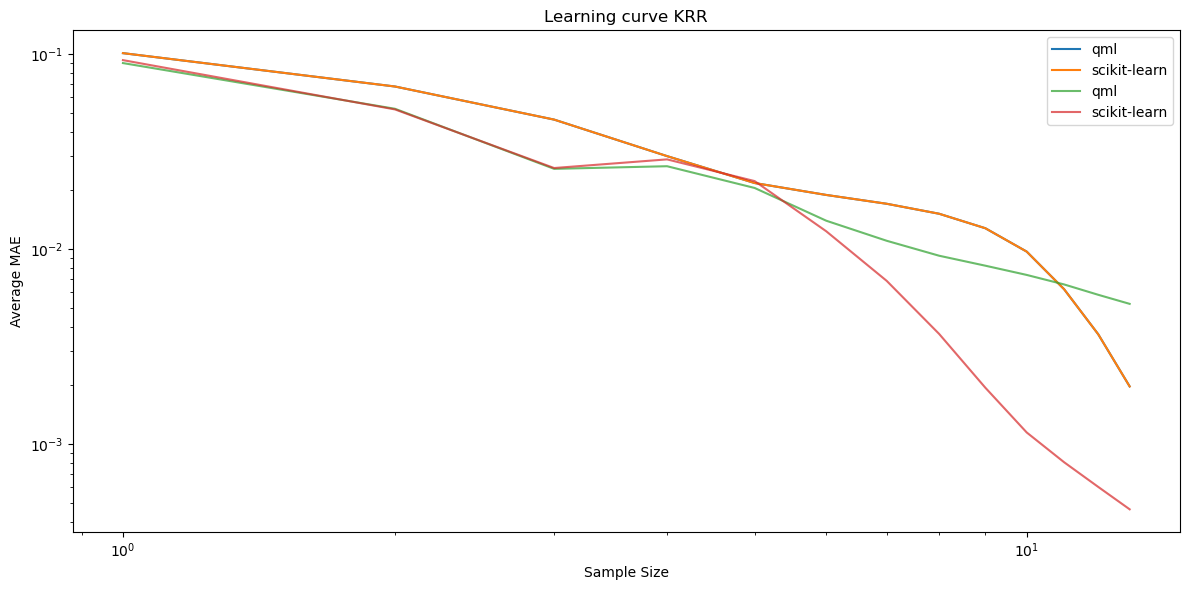

In [57]:
plot_avg_mae(krr_array)

In [54]:
def plot_avg_training(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["qml", "scikit-learn"]
    times_names = ["cpu_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time = np.zeros((13,))
                    for i in range(13):
                        if t  == 1:
                            avg_training_time[i] = krr_array[j, i, l, k].avg_training_time_wall
                        else:
                            avg_training_time[i] = krr_array[j, i, l, k].avg_training_time_cpu
                    axs.plot(np.array([2 ** i for i in range(1, 14)]), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs.set_title(f"Training time plot KRR, Thread(s) = {thread}")
                    axs.set_xlabel("Sample Size")
                    axs.set_ylabel(f"{time_name} in seconds")
                    axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Training_time_CPU.png", dpi = 100)

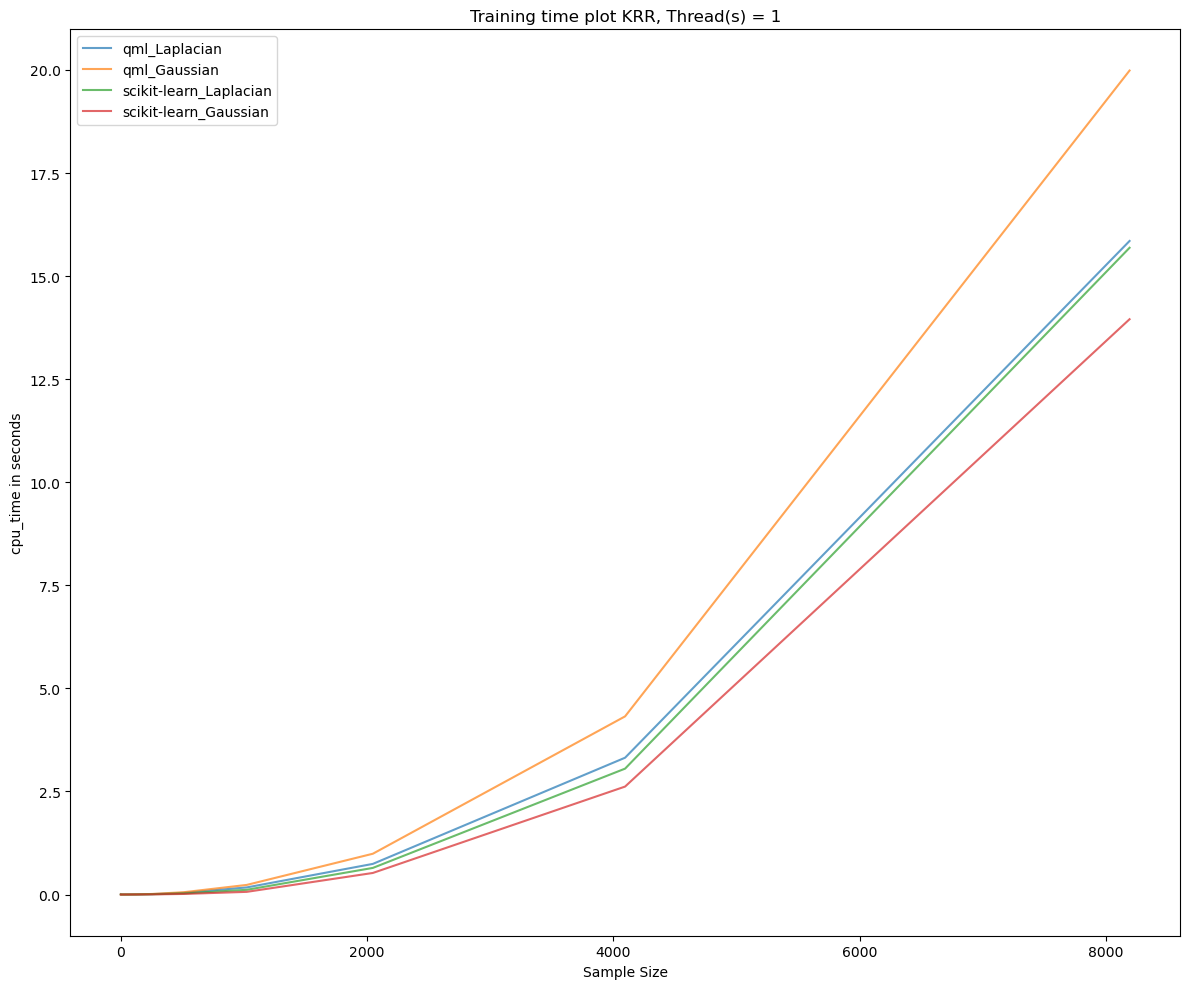

In [55]:
plot_avg_training(krr_array)